In [186]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## Data Collecting and Cleaning

### Loading Dataset

In [187]:
data = pd.read_csv('Visa_For_Lisa_Loan_Modelling.csv', index_col='ID')
data

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0


### Checking for empty & missing values

In [188]:
#show rows with null or missing values (none in this case)

rows_with_na = data[data.isna().any(axis=1)]
rows_with_na.count()


Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

### Correcting CreditCard column values

CreditCard column uses binary system to indicate whether a client has a credit card, where 1 affirmative and 0 is negative. The dataset has an error, indicating CCAvg for some users while not having a CreditCard set to 1. The code below updates the database if client has an active CCAvg and sets CreditCard to 1. The model has shown best results with this step, while setting Credit Card to 0 for 0 in CC Avg has been counterproductive.

In [189]:
#DataFrame.loc[row_indexer, column_indexer]
data.loc[(data['CCAvg'] > 0) & (data['CreditCard'] == 0), 'CreditCard'] = 1
#data.loc[(data['CCAvg'] == 0) & (data['CreditCard'] == 1), 'CreditCard'] = 0
data

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,1
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,1
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,1
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,1
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,1
4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,1
4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,1


### Looking for similarities between those who accepted personal loans and those who declined

In [190]:
data.groupby('Personal Loan').mean()


,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
Personal Loan,,,,,,,,,,,,
0,45.367257,20.132301,66.237389,93152.428761,2.373451,1.729009,1.843584,51.789381,0.102212,0.035841,0.595796,0.982965
1,45.066667,19.843750,144.745833,93153.202083,2.612500,3.905354,2.233333,100.845833,0.125000,0.291667,0.606250,0.997917


In [191]:
data.groupby('Personal Loan').median()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
Personal Loan,,,,,,,,,,,,
0,45.0,20.0,59.0,93437.0,2.0,1.4,2.0,0.0,0.0,0.0,1.0,1.0
1,45.0,20.0,142.5,93407.0,3.0,3.8,2.0,0.0,0.0,0.0,1.0,1.0


As we can see from the charts above, some information is very similar while show differemces and/or omit important ques about clients. For example, not all clients have mortgage, yet those who do not are being counted towards average. How many personal loan clients even have one? What's the maximum percentage of CC Average in relation to income of clients who accepted a loan? Etc.

Let's take a look at some of those (more in the slides): 

In [192]:
accepted = data[data['Personal Loan'] == 1]
mortgage = accepted[accepted['Mortgage'] > 0]
no_mortgage = accepted[accepted['Mortgage'] == 0]
ccavg_ratio_accepted = accepted['CCAvg'] / accepted['Income']
#
print(ccavg_ratio_accepted.sort_values(ascending=False).head(5))


ID
1919    0.050847
1604    0.050725
3823    0.050562
1065    0.050000
1340    0.050000
dtype: float64


Let's check average mortgage of clients who have an active mortgage and take a look how the numbers will change:

In [193]:
#Checking how many people have a mortgage and finding an average of their mortage: 168 people and $288,131 average morgage
print(mortgage["Mortgage"].count())
print(mortgage["Mortgage"].mean())

168
288.1309523809524


Calculating percentage of clients who have accepted a loan AND have an active mortgage

In [194]:
#Checking ratio of people with mortgage to overall clients who accepted a loan: 35% of personal loan clients have a mortgage
mortgage_ratio = mortgage["Mortgage"].count()/(accepted["Mortgage"]).count()
print(mortgage_ratio)

0.35


In [195]:
#Checking maximum acceptable CCAvg ratio to Income: 5.08% of income is the maximum CC Avg for a client who accepted a loan

ccavg_ratio_accepted = accepted['CCAvg'] / accepted['Income']
print(ccavg_ratio_accepted.sort_values(ascending=False).head(5))

ID
1919    0.050847
1604    0.050725
3823    0.050562
1065    0.050000
1340    0.050000
dtype: float64


### Preparing dataset for model training

In [196]:
X = data.drop('Personal Loan', axis=1) #droping column that we are checking
y = data['Personal Loan'] #column that we are checking


### Model Training

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #random state shuffles the date before splitting and produces the same split each time

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Model Testing and Results

In [198]:
y_pred = classifier.predict(X_test)

print("Random Forest Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Model Accuracy: 0.9933333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1356
           1       0.99      0.94      0.96       144

    accuracy                           0.99      1500
   macro avg       0.99      0.97      0.98      1500
weighted avg       0.99      0.99      0.99      1500



### Top Decision-Making Criteria
Top-4 Criteria account for 78% of decisions, but let's capture over 80% with top-5

Income        0.311770
Education     0.182470
CCAvg         0.165811
Family        0.120543
CD Account    0.051120
Experience    0.040998
Mortgage      0.039029
Age           0.038603
ZIP Code      0.037646
Online        0.007400
dtype: float64


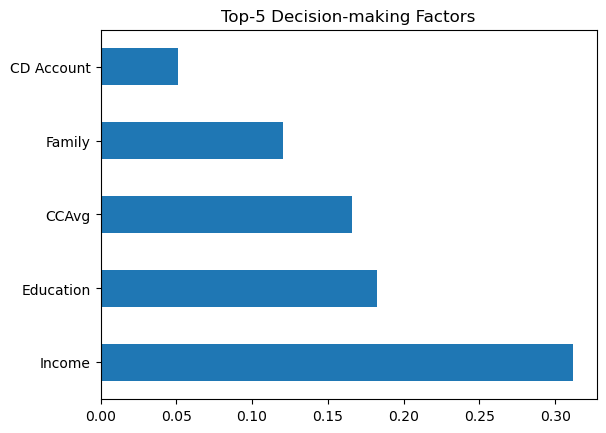

In [199]:
feature_importance = pd.Series(classifier.feature_importances_, index=X.columns)
print(feature_importance.nlargest(10))

feature_importance.nlargest(5).plot(kind='barh')
plt.title("Top-5 Decision-making Factors")
plt.show()
